You are a Data Analyst at a travel research firm tasked with analyzing Airbnb activity in Asheville, NC. Your goal is to evaluate pricing, demand and host activity trends to help a travel startup decide whether to expand services in Asheville.

1) What pricing trends look like?
2) Which neighborhoods and hosts are most active?
3) What review activity says about demand?

## 1) Data Preparation


In [1]:
# Loading libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [2]:
# Load the listings data
listings = pd.read_csv("listings.csv")

listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,NaN
1,197263,Tranquil Room & Private Bath,961396,Timothy,NaN,28806,35.577350,-82.638040,Private room,44.0,2,87,2024-09-08,0.56,2,73,5,NaN
2,209068,Terrace Cottage,1029919,Kevin,NaN,28804,35.617641,-82.551819,Entire home/apt,90.0,30,67,2025-05-03,0.40,1,268,2,NaN
3,246315,Asheville Dreamer's Cabin,1292070,Annie,NaN,28805,35.596150,-82.506350,Private room,61.0,7,53,2019-10-30,0.32,3,62,0,NaN
4,314540,Asheville Urban Farmhouse Entire Home 4.6 mi t...,381660,Tom,NaN,28806,35.585610,-82.627310,Entire home/apt,200.0,1,35,2025-06-13,0.22,1,139,11,NaN


In [3]:
# Check the shape
listings.shape

(2876, 18)

The dataset contains 2876 rows and 18 columns.

In [4]:
# Check the dtypes and null
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2876 non-null   int64  
 1   name                            2876 non-null   object 
 2   host_id                         2876 non-null   int64  
 3   host_name                       2876 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   2876 non-null   int64  
 6   latitude                        2876 non-null   float64
 7   longitude                       2876 non-null   float64
 8   room_type                       2876 non-null   object 
 9   price                           2536 non-null   float64
 10  minimum_nights                  2876 non-null   int64  
 11  number_of_reviews               2876 non-null   int64  
 12  last_review                     26

There are two main issues from the information above
1. Missing values in `last_review`, `price`, `reviews_per_month`.
2. Datatype mismatch for the `last_review` column. Appears as object instead of datetime. 

In [5]:
# Converting the last_review columns to datetime.

listings["last_review"] = pd.to_datetime(listings["last_review"])

# Checking dtypes to confirm changes
listings.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                      float64
neighbourhood                              int64
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
license                                  float64
dtype: object

In [6]:
# Checking for the span of the last_review date. We will be needing the recent data to guide decision making.

earliest_last_review = listings["last_review"].min()
latest_last_review = listings["last_review"].max()

print(f"Earliest last review: {earliest_last_review}")
print(f"Latest last review: {latest_last_review}")

Earliest last review: 2015-10-03 00:00:00
Latest last review: 2025-06-16 00:00:00


In [7]:
# Filter for data from 2021 and keep listings without any reviews since they may be listings which are not yet reviewed.
recent_listings = listings.query("last_review >= '2021-01-01' or last_review.isna()").copy()

# Confirming the succes of the filtering
recent_listings["last_review"].min(), recent_listings["last_review"].max()

(Timestamp('2021-02-14 00:00:00'), Timestamp('2025-06-16 00:00:00'))

Even though the `last_review` date spans from 2015 to 2025, for this analysis, the focus will be on data from 2021 onwards, which reflects the most recent and stable market conditions following the COVID-19 pandemic. Properties with no reviews for years may be inactive, delisted or irrelevant to current market conditions, hence the exclusion of `last_review` date below 2021. Listing with `NaT` last_reviews were maintained because they may likely represent new unreviewed listings.

In [8]:
# Checking the shape of our working recent listings.
recent_listings.shape

(2852, 18)

In [9]:
# Drop possible duplicates if there are any
recent_listings = recent_listings.drop_duplicates()
recent_listings.shape

(2852, 18)

Comparing our filtered `recent_listings` dataset to the original `listings` dataset shows that 24 records were filtered out. `listings` had 2876 rows and `recent_listings` has 2852 rows. We did not lose much data from filtering.

In [10]:
# Finding the columns that contain null values.
missing_n = recent_listings.isna().sum()
missing_n[missing_n > 0]

neighbourhood_group    2852
price                   334
last_review             263
reviews_per_month       263
license                2852
dtype: int64

In [11]:
# Proportion of the columns that contain null values
missing_pct = recent_listings.isna().mean()
missing_pct[missing_pct > 0]

neighbourhood_group    1.000000
price                  0.117111
last_review            0.092216
reviews_per_month      0.092216
license                1.000000
dtype: float64

`neighbourhood_group` and `license` columns are entirely null.
Close to 12% of the `price` values are missing.
About 9% of the `last_revies` and `reviews_per_month` data are missing. These are likely new and unrewiewed listings.

In [12]:
# Drop the neighbourhood_group and license columns because they are all nulls.
recent_listings.dropna(how= "all",
                       axis=1,
                       inplace=True)

In [13]:
# View the columns to confirm the dropping of the groups.
recent_listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [14]:
# Filling the missing price values with median
median_price = recent_listings["price"].median()
recent_listings["price"] = recent_listings["price"].fillna(median_price)

In [15]:
# Check for null to confirm
recent_listings.isna().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                       263
reviews_per_month                 263
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
dtype: int64

## 2) Descriptive Analysis

With the data initially cleaned and prepared, I proceeded with some descriptive statistics. Further cleaning such as handling outliers was done.

In [27]:
# Check the summary statistics of the other numeric features of the listings
cols_of_interest = ["price", "minimum_nights" ,"number_of_reviews", "reviews_per_month",
                    "calculated_host_listings_count","availability_365","number_of_reviews_ltm"]
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,169.250088,5.134993,109.721950,2.168059,9.133240,224.873422,13.645161
std,141.238739,8.963409,146.645946,1.914802,21.953854,116.930660,17.184220
min,20.000000,1.000000,0.000000,0.026120,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,998.650000,30.000000,741.000000,8.724000,108.000000,365.000000,82.000000


In [28]:
# Checking the skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()})

,Skew,Kurtosis
price,3.305039,13.952368
minimum_nights,2.307816,3.459402
number_of_reviews,2.091938,4.627469
reviews_per_month,1.296234,1.419030
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,1.837766,3.445485


The summary statistics reveal outliers in `price`,`minimum_night` and `number_of_reviews_ltm`. These columns have maximum values which are practically unrealistic and needs to be dealt with to reduce their effect on the analysis. `price` and `minimum_night` are highly positively skewed (large skew values) and with a lot of outliers (large kurtosis).

**Outlier Handling Strategy**

The plan is to get the 1st and 99th percentiles as the minimum and maximim values and replacec all outliers above the 99th percentile with the 99th percentile value and those below the 1st percentile with the 1st percentile values. `number_of_reviews` is an integer column and so was cast as `int`.

In [29]:
# Dealing with outliers

for col in cols_of_interest:
    lower_val, upper_val = listings[col].quantile([0.001, 0.99])

    if col == "number_of_reviews":
        upper_val = int(upper_val)
    
    recent_listings[col] = recent_listings[col].clip(lower = lower_val, upper= upper_val)

In [30]:
# Checking for the effects
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,169.250088,5.134993,109.721950,2.168059,9.133240,224.873422,13.645161
std,141.238739,8.963409,146.645946,1.914802,21.953854,116.930660,17.184220
min,20.000000,1.000000,0.000000,0.026120,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,998.650000,30.000000,741.000000,8.724000,108.000000,365.000000,82.000000


In [31]:
# Add the skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()})

,Skew,Kurtosis
price,3.305039,13.952368
minimum_nights,2.307816,3.459402
number_of_reviews,2.091938,4.627469
reviews_per_month,1.296234,1.419030
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,1.837766,3.445485


There is a significant improvement in the skews and kurtosis after handling the outliers. Also the `price`, `number_of_reviews` and `number_of_reviews_ltm` now have their maximum values capped to their 99th percentiles.

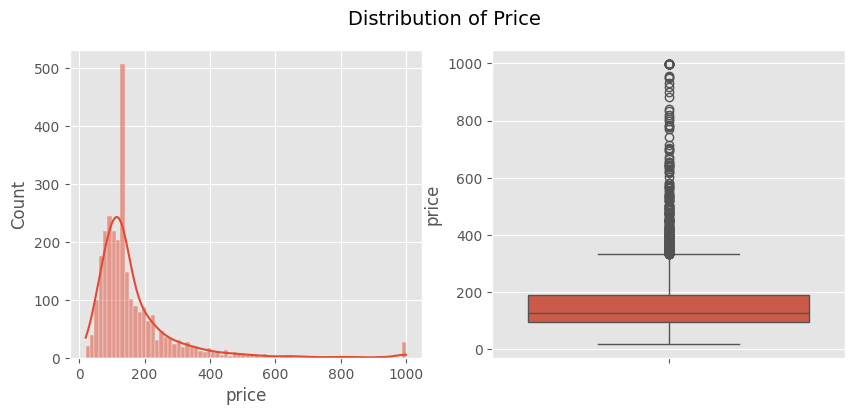

In [32]:
# Visualazing the review_per_month distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()
sns.histplot(x = recent_listings["price"], ax = ax[0], kde = True)

sns.boxplot(y = recent_listings["price"], ax =ax[1])

fig.suptitle("Distribution of Price", fontsize = 14)

plt.show()

The prevailing analysis and visualizations on the price column reveals that the price distribution is rightly skewed with some outliers (skew = 3.3 and kurtosis = 14). Most of the listings are relatively affordable (median = $128). However there are some expensive listings too which may possibly be luxury or premium apartments which is normal in this case.

The average and median price for all listings are `$169.00` and `$127.00` respectively.

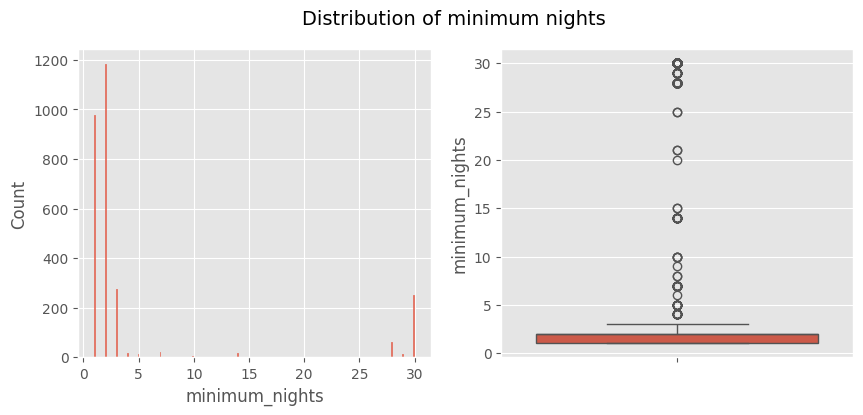

In [33]:
# Visualizing the minimum_nights distribution
fig,ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten
sns.histplot(x = recent_listings["minimum_nights"], ax = ax[0])

sns.boxplot(y = recent_listings["minimum_nights"], ax = ax[1])

fig.suptitle("Distribution of minimum nights", fontsize = 14)
plt.show()

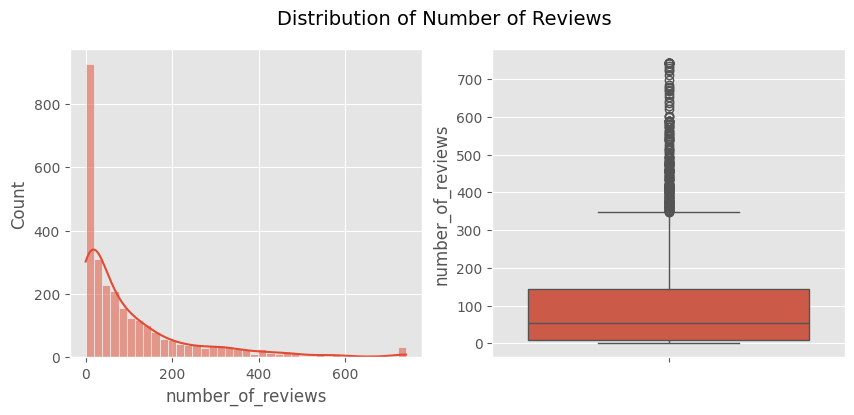

In [34]:
# Visualizing the number of reviews distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()
sns.histplot(x = recent_listings["number_of_reviews"], ax = ax[0], kde= True)

sns.boxplot(y = recent_listings["number_of_reviews"], ax = ax[1])

fig.suptitle("Distribution of Number of Reviews", fontsize = 14)
plt.show()

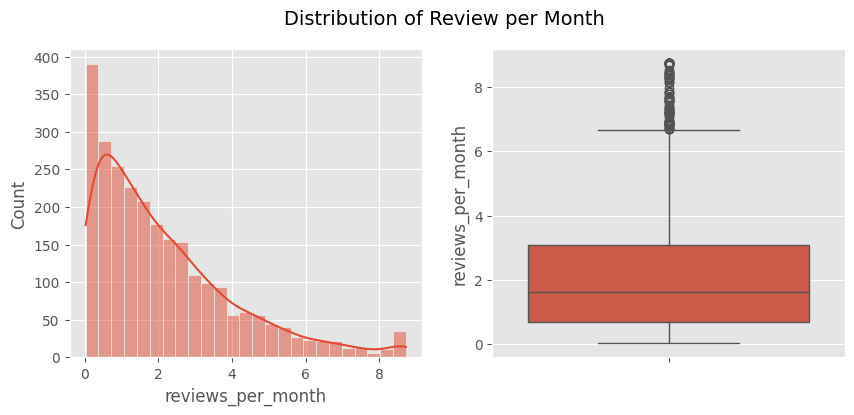

In [35]:
# Visiulazing the review_per_month distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()

sns.histplot(x = recent_listings["reviews_per_month"], ax = ax[0], kde=True)

sns.boxplot(y = recent_listings["reviews_per_month"], ax = ax[1])

fig.suptitle("Distribution of Review per Month", fontsize = 14)
plt.show()

The analysis and visualisations on the `review_per_month` and `number_of_reviews` columns shows that their distribution is right-skewed. The median number of reviews is 53 with an average of 110 reviews. For `reviews_per_month`, most of the values lie below 2 reviews per month (median = 1.64)

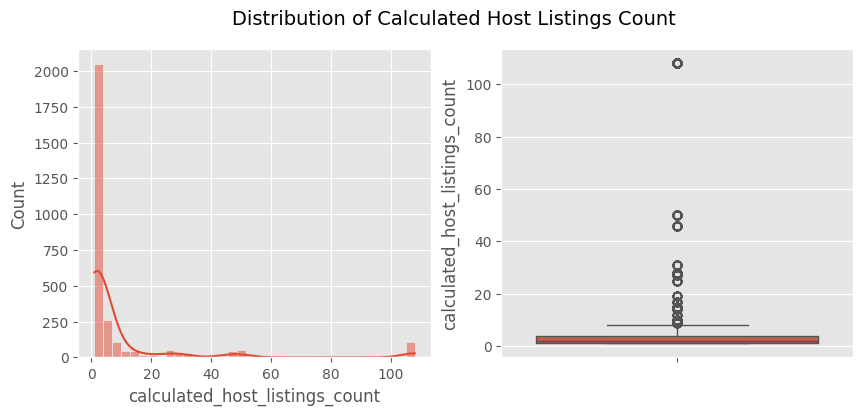

In [37]:
# Visualizing the number of calculated host_listings distribution
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax.flatten()

sns.histplot(x = recent_listings["calculated_host_listings_count"], ax = ax[0], binwidth=3, kde=True)

sns.boxplot(y = recent_listings["calculated_host_listings_count"], ax = ax[1])

fig.suptitle("Distribution of Calculated Host Listings Count", fontsize =14)
plt.show()

The distribution of the `calculated_host_listings_count` shows that most of the hosts have less than 3 listings (median = 2) with a few hosts having more than 10 listings. One host has more than 100 listings somehow.

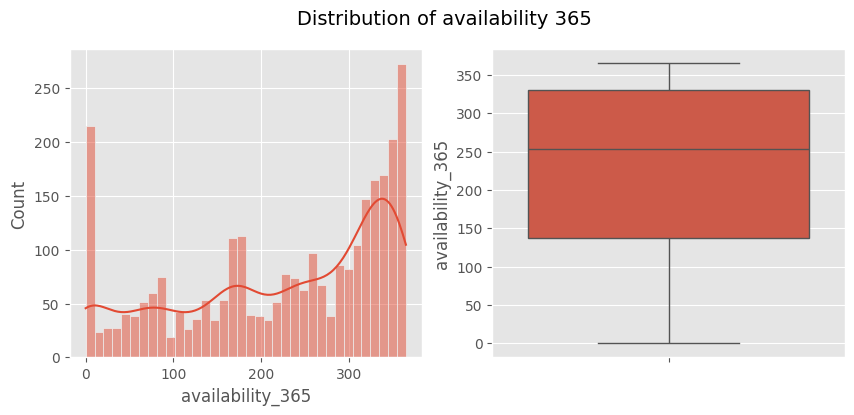

In [39]:
# Visiulazing the number of availability 365
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()

sns.histplot(x = recent_listings["availability_365"], ax = ax[0], binwidth=10, kde = True)

sns.boxplot(y = recent_listings["availability_365"], ax = ax[1])

fig.suptitle("Distribution of availability 365", fontsize = 14)
plt.show()

The distribution of the `availability_365` shows a sligth negatively-skewed distribution. The median availability is 254 days and average of 224 dats. This means that most listings are available for booking for most part of the year. At the extreme left it shows a good number of listings have a small `availability_365` 

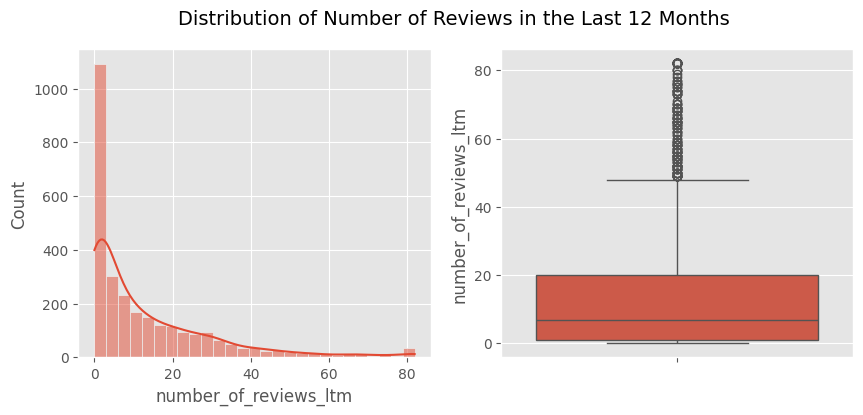

In [40]:
# Visiualizing the number of reviews in the last 12 months distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax.flatten()

sns.histplot(x = recent_listings["number_of_reviews_ltm"], ax = ax[0], binwidth=3,kde=True)

sns.boxplot(y = recent_listings["number_of_reviews_ltm"], ax = ax[1])

fig.suptitle("Distribution of Number of Reviews in the Last 12 Months", fontsize = 14)
plt.show()

The distribution of the number of reviews in the last 12 month also shows a positively skewed distribution. The median is 7 with an average of 12. This means while most listings got under 8 reviews in the last 12 months, few popular ones have recieved a lot reviews in the last 12 months therby driving the mean upwards.

### Different types of rooms listed and their proportions

In [41]:
# Get the different types of room and their count
recent_listings["room_type"].value_counts()

room_type
Entire home/apt    2551
Private room        281
Hotel room           12
Shared room           8
Name: count, dtype: int64

In [42]:
# Find the different types of rooms listed and their proportions.
recent_listings["room_type"].value_counts(normalize=True) * 100

room_type
Entire home/apt    89.446003
Private room        9.852735
Hotel room          0.420757
Shared room         0.280505
Name: proportion, dtype: float64

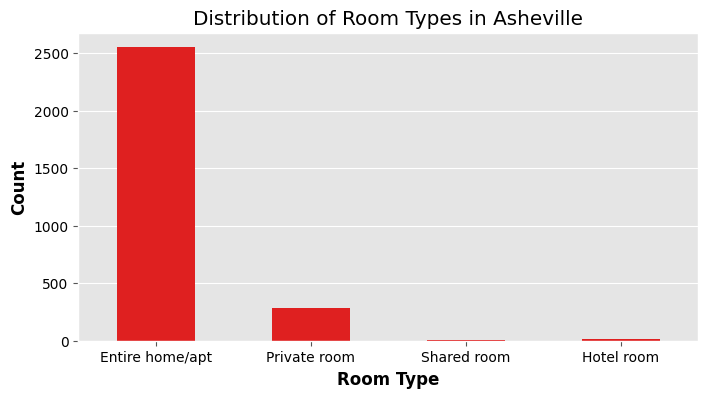

In [45]:
# Showing the distribution of room types
fig,ax = plt.subplots(figsize = (8,4))
sns.countplot(x = recent_listings["room_type"], width=0.5, color="red", ax = ax)

ax.set_title("Distribution of Room Types in Asheville")
ax.set_xlabel("Room Type", fontweight = "bold", color = "black")
ax.set_ylabel("Count", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")

plt.savefig("images/Distribution of room types.png", dpi = 300, bbox_inches = "tight")
plt.show()

The analysis reveals that entire home/apartment is the most common room type having a count of 2551 with a percentage share 89%. Private room has close to 10% share of the room types with a count of 281.

### Number of active listings per neighbourhood

In this analysis active listings can be defined based on 2 assumptions.
1. The mere presence of the property in the listings means it is active.
2. Active listing means availability of a room for booking (availability_365 > 0)

Although the `availability_365` variable indicates how many days a listing is available for booking in the next year, it does not specify why a property has zero available days. A value of 0 may mean that the listing is fully booked (indicating that there is high demand) or blocked by the host (indicating temporary unavailability). Because these two scenarios cannot be distinguished from the dataset alone, excluding listings wiht zero availability could introduce a bias by removing potentially popular or high performing properties. Therefore, this analysis will include all listings present in the dataset, representing the complete snapshot of the Asheville Airbnb market at the time of data collection

In [46]:
# Number of active listings per neighbourhood assuming that the mere presence of
# the property in the listings means it is active
recent_listings.groupby("neighbourhood")["id"].count().sort_values(ascending=False)

neighbourhood
28806    800
28801    588
28803    452
28804    376
28805    281
28704    189
28715     93
28732     73
Name: id, dtype: int64

<Axes: xlabel='neighbourhood'>

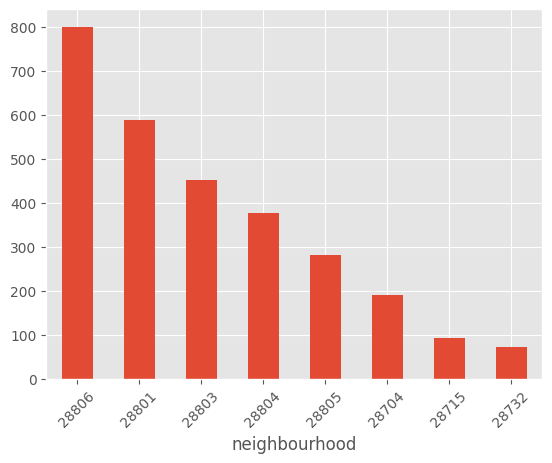

In [47]:
# Count the number of listings in each neighbourhood
recent_listings.groupby("neighbourhood").size().sort_values(ascending=False).plot.bar(rot = 45)

## 3) Price Insights

In [48]:
# Compare average price by neighbourhood
round(recent_listings.groupby("neighbourhood")["price"].mean(),2).sort_values()

neighbourhood
28806    157.64
28715    168.13
28801    170.82
28804    171.59
28805    173.45
28803    174.33
28704    179.93
28732    197.95
Name: price, dtype: float64

<Axes: xlabel='neighbourhood', ylabel='average price'>

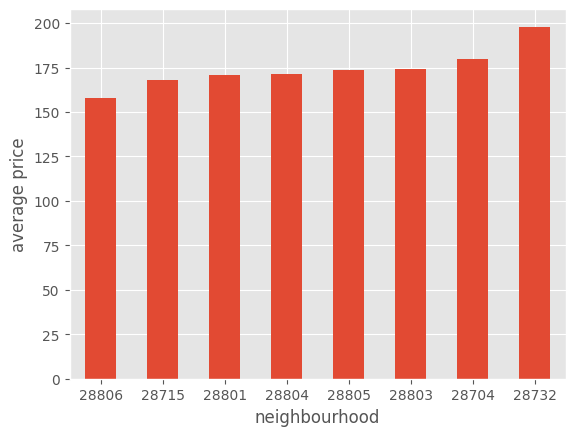

In [49]:
# Visualization of the average price per neighbourhood
round(recent_listings.groupby("neighbourhood")["price"].mean(),2).sort_values().plot(kind = 'bar', rot = 0, ylabel="average price")

Neighbourhood 28806 has the cheapest listings on average. People tight on budget may first look there. Neighbourhood 28732 has the most expensive average price. This neighbourhood could contain luxurios listings to people with exquisite tastes. It is also obvious that neighbourhood 28806 is highly competitive (with 800 listings) forcing hosts to reduce prices to stay competitive. However, the situation may be different on the ground and so requires further background/field checks.

In [50]:
# Identify the top 5 most expensive neighbourhoods.
round(recent_listings.groupby("neighbourhood")["price"].mean(),2).sort_values(ascending=False)[:5]

neighbourhood
28732    197.95
28704    179.93
28803    174.33
28805    173.45
28804    171.59
Name: price, dtype: float64

Above is the top 5 most expensive neighbourhoods

<Axes: xlabel='minimum_nights'>

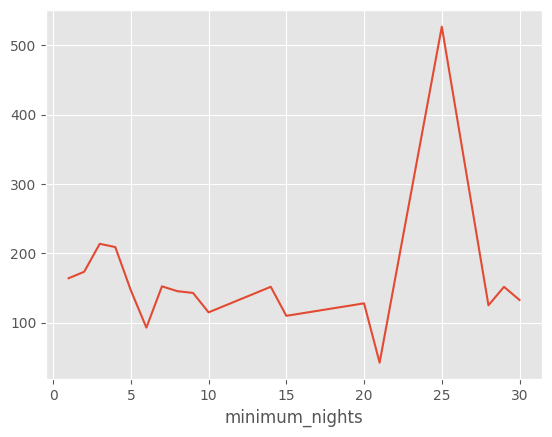

In [52]:
# Check if minimum nights affect average price (We will do this by plotting a scatter plot of minimum night against average price)
recent_listings.groupby("minimum_nights")["price"].mean().plot()

In [53]:
# Is there a correlation between minimum_nights and price
recent_listings[["minimum_nights", "price"]].corr()

,minimum_nights,price
minimum_nights,1.000000,-0.087424
price,-0.087424,1.000000


In [54]:
# Average price per room type
recent_listings.groupby("room_type")["price"].mean()

room_type
Entire home/apt    176.975147
Hotel room         230.416667
Private room       100.265658
Shared room         37.250000
Name: price, dtype: float64

The analysis and visualisation shows that there is no clear trend between minimum_nights and average price. There is almost no correlation between `minimum_nights` and `price` althoug one would ordinarily expect that price should reduce, even slighly as minimum_nights increased.

## 4) Review and Demand Analysis

The goal here is to:
- Calculate the total number of reviews per listing and the average reviews per month.
- Identify which neighbourhoods generate the most guest activity.
- Look at trends in reviews.csv => which years/months had spikes in demand?

I approached this by merging the `recent_listings` dataframe with the `reviews` dataframe using an inner join so that only listings with review information was included. This operation automatically filtered out the recent listings with null last_review date since they have no corresponding data in the `reviews` dataframe. The the merged data was filtered for recent review_activities between 2021 and 2024 as `recent_reviews`.

In [55]:
# Read the reviews data
reviews = pd.read_csv("reviews.csv")

reviews.head()

,listing_id,date
0,155305,2011-07-31
1,155305,2011-08-23
2,155305,2011-09-19
3,155305,2011-10-28
4,155305,2012-07-01


In [56]:
# Check the shape of the reviews dataframe
reviews.shape

(318549, 2)

In [57]:
# Check for datatypes and null
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318549 entries, 0 to 318548
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  318549 non-null  int64 
 1   date        318549 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.9+ MB


There are no missing values in the listings dataset. However, the date column appeared as `object` type instead of `datetime` type.

In [58]:
# Convert the date column to the datetime type
reviews["date"] = pd.to_datetime(reviews["date"])

# Confirming changes
reviews.dtypes

listing_id             int64
date          datetime64[ns]
dtype: object

In [60]:
# Number of unique listings in the reviews dataset
reviews["listing_id"].nunique()

2613

In [61]:
# Check the date span of reviews
reviews["date"].min(), reviews["date"].max()

(Timestamp('2011-07-31 00:00:00'), Timestamp('2025-06-16 00:00:00'))

The reviews span from 2011 to 2025

In [62]:
# Check the number of reviews per each listing in descending order
reviews.groupby("listing_id")["date"].count().sort_values(ascending=False).head()

listing_id
3314819    1448
2411109    1253
2296152    1136
881707     1096
6054250    1052
Name: date, dtype: int64

The next action is to merge the reviews dataset with the listings dataset on ID so that we get the full data for when each property was reviewed.

I then filtered the full data to get recent reviews (from 2021 to 2024) which reflects the most recent and stable market conditions following the COVID 19 pandemic. Recent data is needed to see the current trends of Airbnb to advise and guide the startup. Including older years can affect the analysis since the market might have evolved. 2025 will be excluded since the year has not ended.

In [63]:
# Merge the listings data with reviews before proceeding
# Inner join to exclude listed facilities that ghave never been reviewed.
full_data = (recent_listings.rename(columns= {"id" : "listing_id"})
             .merge(reviews.rename(columns= {"date": "review_date"}),
                    how="inner",
                    on = "listing_id")
            )

full_data.head()

,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,review_date
0,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2011-07-31
1,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2011-08-23
2,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2011-09-19
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2011-10-28
4,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2012-07-01


In [64]:
full_data.isna().sum()

listing_id                        0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
review_date                       0
dtype: int64

There are no missing values because listings with missing last_review dates have been filtered out during the inner join operation

In [65]:
# Merge the listings data with reviews before proceeding
recent_reviews = full_data.query("'2021-01-01' <= review_date <= '2024-12-31'").copy()

recent_reviews.head()

,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,review_date
280,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2021-01-03
281,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2021-01-17
282,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2021-01-23
283,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2021-01-24
284,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,2021-02-07


When filtering reviews between 2021 - 2025, listings without any associated reviews were automatically excluded, as they had no review dates within this range.

In [66]:
# Check the earliest and latest review dates
recent_reviews["review_date"].min(), recent_reviews["review_date"].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [67]:
# Check the dtypes again
recent_reviews.dtypes

listing_id                                 int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood                              int64
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
review_date                       datetime64[ns]
dtype: object

In [68]:
# Check the shape of the recent reviews data
recent_reviews.shape

(199259, 17)

`neighbourhood.csv` doesn't seen to contain any useful information. The entire `neighbourhood_group` is null and the neighbourhood values are all contained in the reviews dataset and so I found no use for it in this analysis.

- Calculate the total number of reviews per listing and the average reviews per month.
- Identify which neighbourhoods generate the most guest activity.
- Look at trends in reviews.csv => which years/months had spikes in demand.

### Calculate the total number of reviews per listing and the average reviews per month.

In [69]:
# Calculate the total number of reviews per listing and the average reviews per month
recent_reviews.groupby("listing_id")["review_date"].count().sort_values(ascending=False)

listing_id
40274759               746
3314819                575
29073142               516
23859316               495
32424479               484
                      ... 
1298841958485050283      1
1198397997585403570      1
1195836118520563722      1
1229884029804031798      1
1313341642086842027      1
Name: review_date, Length: 2439, dtype: int64

### Identify which neighbourhoods generate the most guest activity.

In [70]:
# Identify which neighbourhoods generate the most guest activity.
(recent_reviews
    .groupby("neighbourhood")["review_date"]
    .count()
    .sort_values(ascending = False)
)

neighbourhood
28806    54863
28801    46713
28804    29900
28803    28542
28805    18982
28704    10365
28715     5611
28732     4283
Name: review_date, dtype: int64

Neighbourhoods 28806, 28801, 28804, 28803 and 28805 are the top 5 neighbourhoods that generate most guest activity.